# Detection color area

Author : Johan Jublanc
    
Date : 06/11/2019

Description : 
- detect area with a particular color
- set bounding box around the area

In [1]:
import json
import shutil
import random
import pathlib
import sys, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import IPython.display as display

import mlflow
import mlflow.tensorflow
import mlflow.keras

import tensorflow as tf

from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.losses import MSE, MSLE
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

from xebikart.images import transformer as T
import xebikart.dataset as dataset

from sklearn.model_selection import train_test_split

%matplotlib inline

/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

using donkey version: 2.5.8 ...


In [2]:
tf.__version__

'1.14.0'

In [3]:
tf.test.is_gpu_available()

False

Eager Execution allows to evaluate operations immediately without building graphs
note : Only needed when not using TF 2.0

In [4]:
tf.enable_eager_execution()

# Parameters

In [5]:
tubes_root_folder = "file:/workspace/xebikart-ml-tubes"
test_size=0.2

# orange obstacle
# tubes_folders = ["tub.v9.orange"]
tubes_folders = ["tub_44_19-11-19"]

### Plot some examples

49152/45695 [================================] - 0s 0us/step
size : 21 images


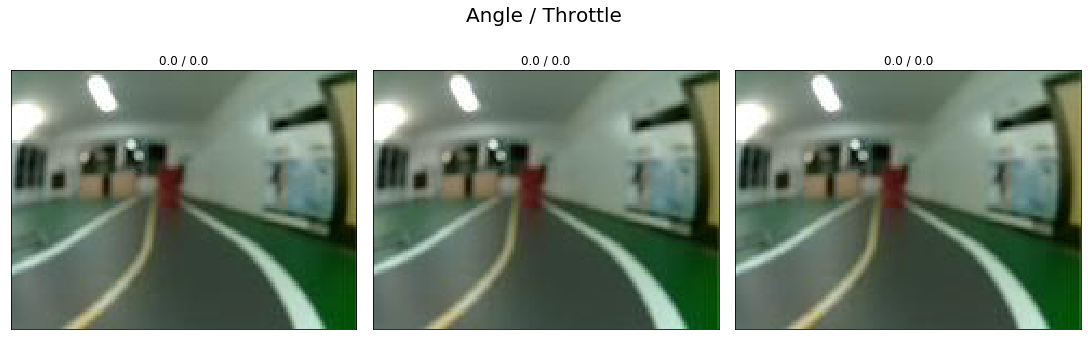

In [6]:
raw_tubes_df = dataset.get_tubes_df(tubes_root_folder, tubes_folders, tubes_extension=".tar.gz")
tubes_df = raw_tubes_df.rename(columns={"cam/image_array": "images_path", "user/angle": "angles", "user/throttle": "throttles"})
tubes_df.count()

fig, axs = plt.subplots(1, 3, figsize=(15,5), constrained_layout=True)
fig.suptitle("Angle / Throttle", fontsize=20)

for n, sample in tubes_df.sample(3).reset_index().iterrows():
    random_image_path = sample["images_path"]
    angle = sample["angles"]
    throttle = sample["throttles"]
    image = mpimg.imread(random_image_path) 
    axs[n].set_title(f"{angle} / {throttle}")
    axs[n].imshow(image)
    axs[n].get_xaxis().set_visible(False)
    axs[n].get_yaxis().set_visible(False)
print("size : {} images".format(len(raw_tubes_df)))

# Pick up a color

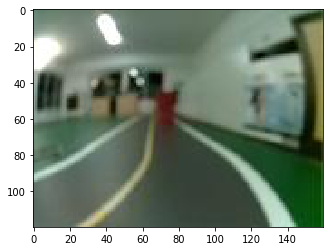

In [15]:
random_image_path = tubes_df.sample(1)["images_path"].values[0]
picked_up_pix = (42, 60)
image = mpimg.imread(random_image_path) 
plt.imshow(image)

In [16]:
def adjust_image(tf_image, gain = 1.5,  saturation = 1.5, constraste = 1.2):
    image_gain = tf.image.adjust_gamma(tf_image, gamma=1, gain=gain)
    image_saturation = tf.image.adjust_saturation(image_gain, saturation)
    image_contrast = tf.image.adjust_contrast(image_saturation, constraste)
    
    return image_contrast

In [23]:
gain = 1.7
saturation = 1
constraste = 1

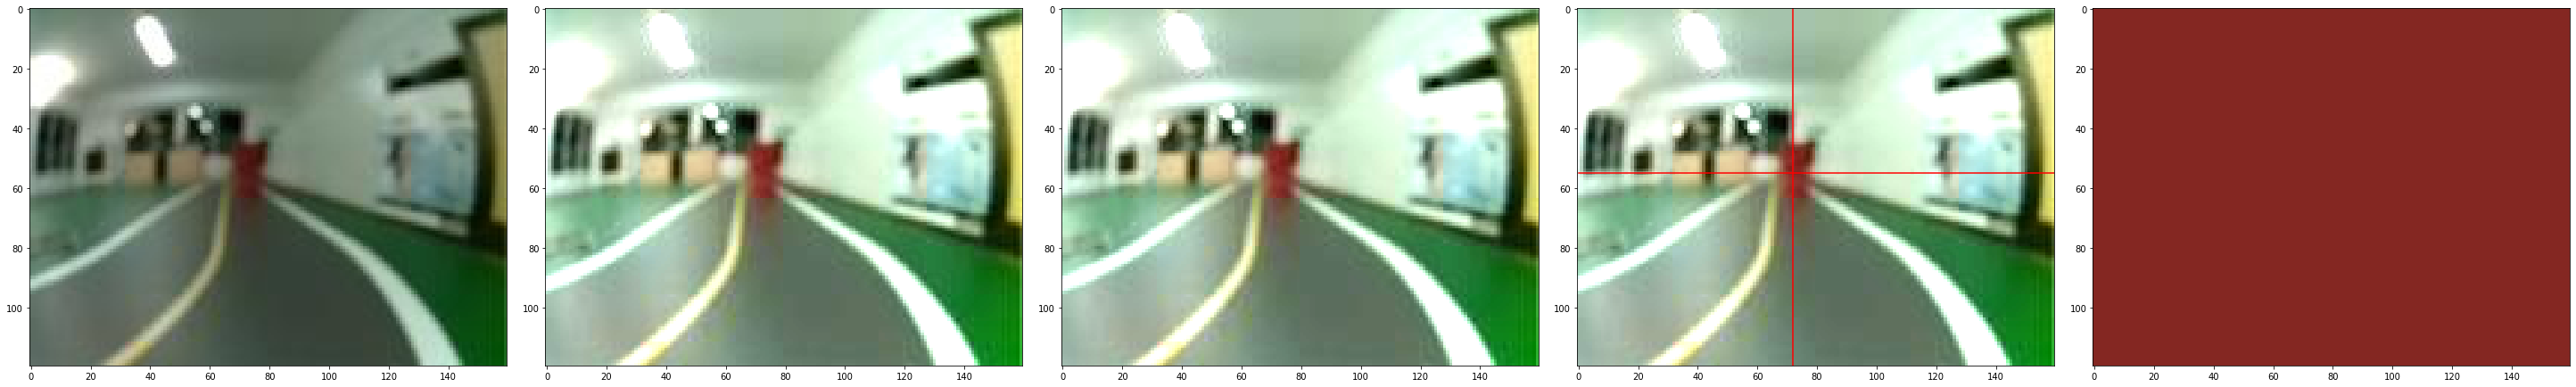

In [26]:
picked_up_pix_yx = (55, 72)

image = mpimg.imread(random_image_path)
image_gain = tf.image.adjust_gamma(image, gamma=1, gain=gain)
image_saturation = tf.image.adjust_saturation(image_gain, saturation)
image_contrast = tf.image.adjust_contrast(image_saturation, constraste)
color_detected = image_contrast[picked_up_pix_yx[0],picked_up_pix_yx[1]]
color = tf.concat([tf.expand_dims(tf.fill([120, 160], color_detected[0]),-1),
                   tf.expand_dims(tf.fill([120, 160], color_detected[1]),-1),
                   tf.expand_dims(tf.fill([120, 160], color_detected[2]),-1)],2)

fig, axs = plt.subplots(1, 5, figsize=(40,40), constrained_layout=True)
axs[0].imshow(image)
axs[1].imshow(image_gain)
axs[2].imshow(image_saturation)

axs[3].plot((picked_up_pix_yx[1],picked_up_pix_yx[1]), (0,120), c="red")
axs[3].plot((0,160), (picked_up_pix_yx[0],picked_up_pix_yx[0]), c="red")
axs[3].imshow(image_contrast)
axs[4].imshow(color)

In [27]:
color_detected

<tf.Tensor: id=383, shape=(3,), dtype=uint8, numpy=array([132,  39,  34], dtype=uint8)>

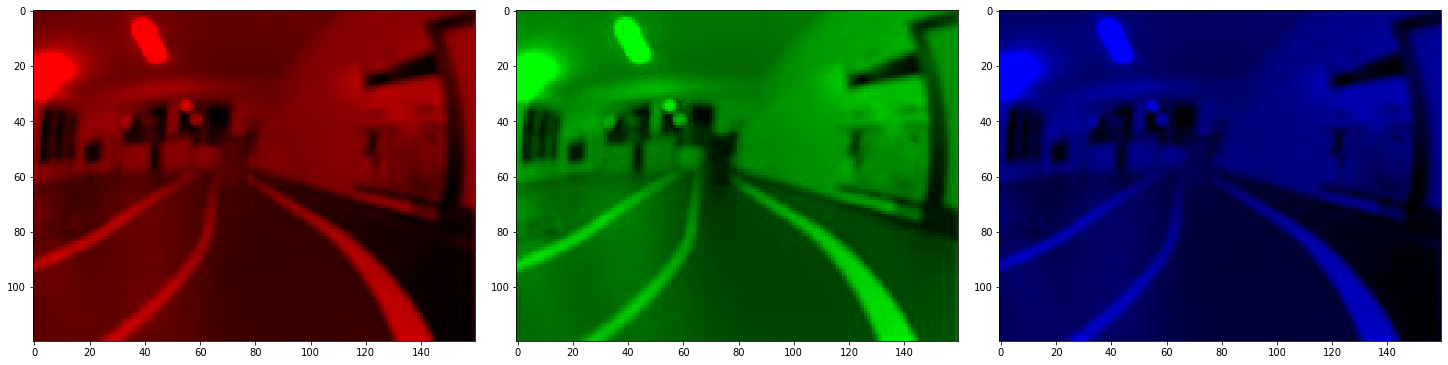

In [51]:
image_chan_r = tf.concat([tf.expand_dims(image[:,:,0],-1),
                          tf.expand_dims(tf.fill([120, 160], tf.dtypes.cast(0,tf.uint8)),-1),
                          tf.expand_dims(tf.fill([120, 160], tf.dtypes.cast(0,tf.uint8)),-1)],2)

image_chan_g = tf.concat([tf.expand_dims(tf.fill([120, 160], tf.dtypes.cast(0,tf.uint8)),-1),
                          tf.expand_dims(image[:,:,1],-1),
                          tf.expand_dims(tf.fill([120, 160], tf.dtypes.cast(0,tf.uint8)),-1)],2)

image_chan_b = tf.concat([tf.expand_dims(tf.fill([120, 160], tf.dtypes.cast(0,tf.uint8)),-1),
                          tf.expand_dims(tf.fill([120, 160], tf.dtypes.cast(0,tf.uint8)),-1),
                          tf.expand_dims(image[:,:,0],-1)],2)

fig, axs = plt.subplots(1, 3, figsize=(20,20), constrained_layout=True)
axs[0].imshow(image_chan_r)
axs[1].imshow(image_chan_g)
axs[2].imshow(image_chan_b)

# 1/ Build a mask corresponding to the area

Here we detect pixels corresponding to the color chosen with a margin of error. To be more accurate, each pixel $pix_i$ is composed of 3 values between 0 and 255, one for each color channel (red, green, blue).

The formula we use is as follow : 
$$mask_i = \mathbb{1}_{pix_i(R) = color(R) +/- \epsilon}\times \mathbb{1}_{pix_i(G) = color(G) +/- \epsilon} \times \mathbb{1}_{pix_i(B) = color(B) +/- \epsilon}$$

Where : 
- $mask_i$ is the pixel i of the one-channel image output (one channel beacause we just need a black and white mask)
- $pix_i(R/G/B)$ value of the channel red/green/blue for the pixel $i$
- $color(R/G/B)$ value of the channel red/green/blue for the color detected.

That function keep the pixels that correspond to color that we want to detect for each RGB channel with amargin of error $\epsilon$. The other pixels are ignored. For the pixel kept we return 1 and for the other we return 0.

NB : for practical reason the following function inverse ones and zeros (we want to put the colored detected in black).

In [32]:
def detect_color_area(tf_image_original, color_to_detect, epsilon):
    tf_image_original = tf.dtypes.cast(tf_image_original, tf.float32)
    color_to_detect = tf.dtypes.cast(color_to_detect, tf.float32)
    tf_boolean_channels = []
    
    for i in range(len(color_to_detect)):
        tf_ = tf.where(((tf_image_original[:,:,i] < (color_to_detect[i] + epsilon[i]))&
                        (tf_image_original[:,:,i] > (color_to_detect[i] - epsilon[i]))), 
                 tf.ones_like(tf_image_original[:,:,i]),
                 tf.zeros_like(tf_image_original[:,:,i]))
                 
        
        tf_boolean_channels.append(tf.expand_dims(tf_, axis=0, name=None))
        
    tf_sum = tf.math.reduce_sum(tf.concat(tf_boolean_channels, 0),0)
        
    return tf.where(tf_sum >= 3, tf.zeros_like(tf_sum), tf.ones_like(tf_sum))

## 1.1/ Plot somme examples

In [30]:
tubes_sample = tubes_df.sample(10)["images_path"].values[0:12]

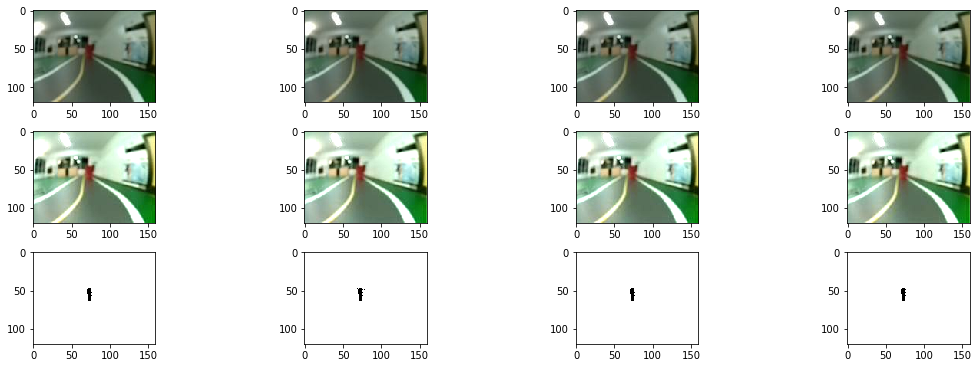

In [52]:
epsilon = [30,20,80]

fig, axs = plt.subplots(3, 4, figsize=(15,5), constrained_layout=True)
for i in range(4):
    # function pre-defined are used to compute the prediction
    tf_image = T.read_image(tubes_sample[i])
    image_gain = tf.image.adjust_gamma(tf_image, gamma=1, gain=gain)
    image_saturation = tf.image.adjust_saturation(image_gain, saturation)
    image_contrast = tf.image.adjust_contrast(image_saturation, constraste)
    
    # eaxh image in shown with the prediction
    axs[0][i].imshow(tf_image)
    axs[1][i].imshow(image_contrast)
    axs[2][i].imshow(detect_color_area(image_contrast, color_to_detect = color_detected , epsilon=epsilon), cmap="gray")

# 2/ Set a bounding box around the area

Here we sum detected pixel along each axis and keep the position for which at least $n$ pixels have been detected, where $n$ is a parameter. The for each axis we return the min and max positions where at least $n$ pixels have been detected.

In [53]:
def bounding_shape_in_box(tf_binary_mask, nb_pixel_min):
    min_axis = []
    max_axis = []
    
    for i in range(2):
        threshold = tf_binary_mask.shape[i] - nb_pixel_min
        tf_sum_axisi = tf.math.reduce_sum(tf_binary_mask, axis=i)
        min_ = tf.math.reduce_min(tf.where(tf_sum_axisi <= int(threshold)))
        max_ = tf.math.reduce_max(tf.where(tf_sum_axisi <= int(threshold)))
        min_axis.append(min_/tf_binary_mask.shape[(1-i)])
        max_axis.append(max_/tf_binary_mask.shape[(1-i)])
    
    box = [min_axis[1], min_axis[0], max_axis[1], max_axis[0]]
    box = tf.expand_dims(tf.expand_dims(box,0),0)
    
    return tf.dtypes.cast(box,dtype = tf.float32)

In [54]:
def return_image_and_box(image_path, color_detected, epsilon, nb_pixel_min, gain = 1, output_original = True):
    tf_image_original   = T.read_image(image_path)
    tf_image_adjusted = adjust_image(tf_image_original, gain = 1.5,  saturation = 1.5, constraste = 1.2)

    # Create a detection mask
    tf_color_area = detect_color_area(tf_image_adjusted, color_detected, epsilon)
    
    # Create the boudning box
    box = bounding_shape_in_box(tf_color_area, nb_pixel_min)

    # Normilaze the original image
    if output_original :
        tf_image_normalized = tf.image.convert_image_dtype(tf_image_original, dtype=tf.float32)
    else :
        tf_image_normalized = tf.image.convert_image_dtype(tf_image_adjusted, dtype=tf.float32)
    
    tf_image_normalized = tf.expand_dims(tf_image_normalized, 0)
    
    return tf.image.draw_bounding_boxes(tf_image_normalized, box)[0,:,:,:]

## 2.1/ Plot some examples

In [55]:
nb_pixel_min = 3
r = 12

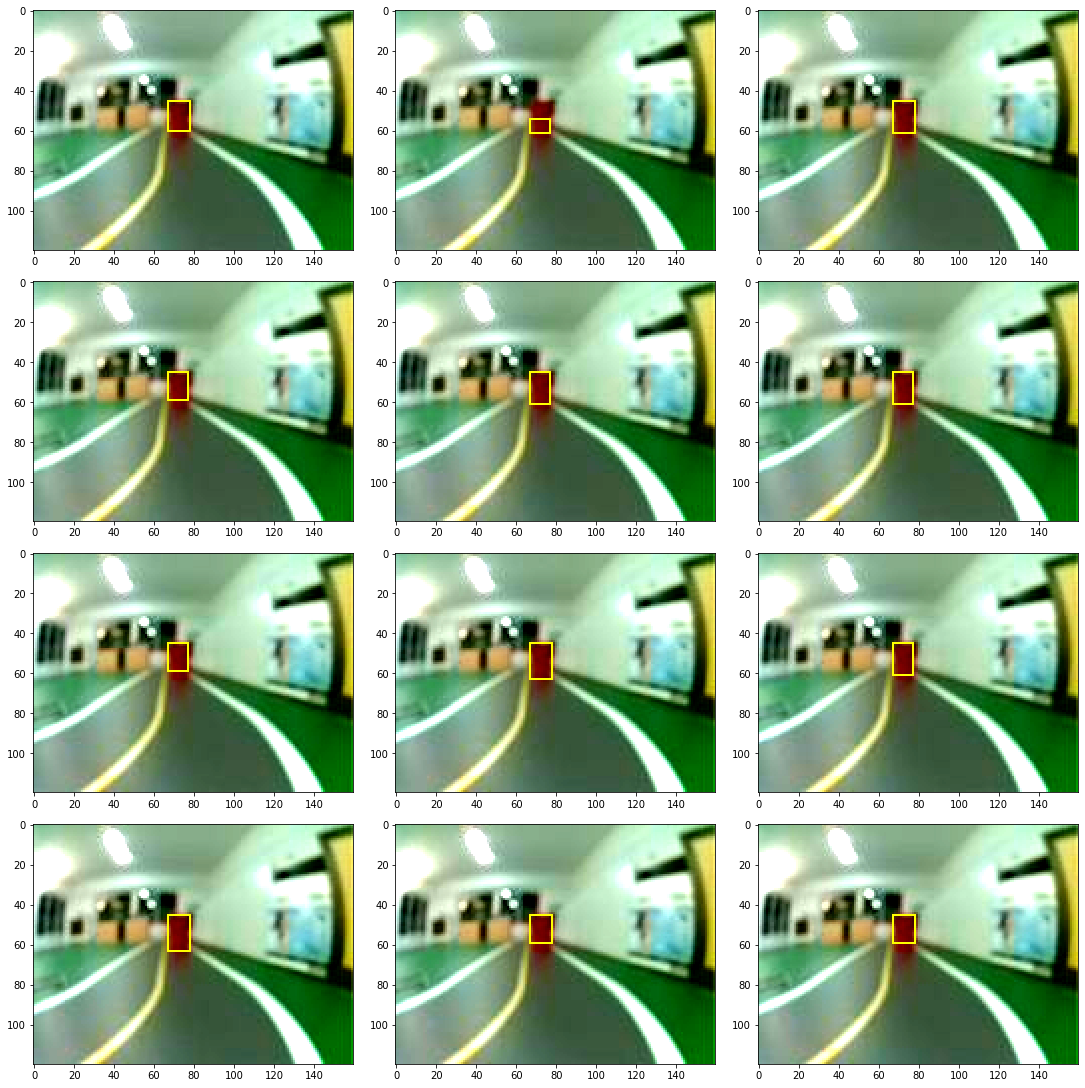

In [56]:
fig, axs = plt.subplots(4, 3, figsize=(15,15), constrained_layout=True)
import time
from IPython.display import clear_output


for i in range(r):
    random_image_path = tubes_df["images_path"].values[i]
    img = return_image_and_box(random_image_path, color_detected, epsilon, nb_pixel_min, gain=gain, output_original = False)
    axs[i//3][i%3].imshow(img)